<a href="https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/sc/notebooks/scanpy_nucleus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-nucleus RNA-seq: Scanpy (python)

[Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/sc/notebooks/scanpy.ipynb)

This notebook demonstrates pre-processing and basic analysis of the [1k Brain Nuclei from an E18 Mouse dataset](https://www.10xgenomics.com/datasets/1-k-brain-nuclei-from-an-e-18-mouse-2-standard-2-0-1) from 10x genomics (version 2 chemistry). Following pre-processing using kallisto/bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is about 45 minutes.

This analysis is the same as single-cell RNA-seq except the index is created using the `--workflow=nac` argument in `kb ref` to capture both nascent and mature transcripts 

.. note::
    `kb count` is run using the standard workflow; the nac workflow for `kb count` is only used if you want to separate out the nascent and mature RNA counts).

The notebook was written by Delaney K. Sullivan, Joseph Rich, and Lior Pachter based off other notebooks written by Kyung Hoi (Joseph) Min, A. Sina Booeshaghi, Joseph Rich, and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

* Melsted P, Booeshaghi AS, Liu L, Gao F, Lu L, Min KHJ, et al. Modular, efficient and constant-memory single-cell RNA-seq preprocessing. Nat Biotechnol. 2021 Jul;39(7):813–8.
* Sullivan DK, Hjörleifsson KE, Swarna NP, Oakes C, Holley G, Melsted P, Pachter L. Accurate quantification of nascent and mature RNAs from single-cell and single-nucleus RNA-seq [Internet]. Nucleic Acids Research. 2025 Jan;53(1):gkae1137
* Sullivan DK, Min KH (Joseph), Hjörleifsson KE, Luebbert L, Holley G, Moses L, et al. kallisto, bustools, and kb-python for quantifying bulk, single-cell, and single-nucleus RNA-seq [Internet]. Nat Protoc. 2024.

See the [kb-python tutorials](https://kallisto.readthedocs.io/en/latest/) site for additional notebooks demonstrating other analyses.

## Setup

In [1]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
%%time
!pip install --quiet scanpy python-igraph louvain pybiomart
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy

!pip install --quiet kb-python==0.29.1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 51

In [3]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
set_matplotlib_formats('retina')

### Download the scRNA-seq data

In [4]:
%%time
!wget -q https://cf.10xgenomics.com/samples/cell-exp/2.0.1/nuclei_900/nuclei_900_fastqs.tar
!tar -xf nuclei_900_fastqs.tar

CPU times: user 496 ms, sys: 102 ms, total: 598 ms
Wall time: 1min 47s


In [5]:
%%time
!kb ref --workflow=nac -d mouse -i index.idx -g t2g.txt -c1 cdna.txt -c2 nascent.txt

[2025-02-07 01:31:58,921]    INFO [download] Downloading files for mouse (nac workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_nac.tar.xz to tmp/mouse_index_nac.tar.xz
100% 965M/965M [00:29<00:00, 34.1MB/s]
[2025-02-07 01:32:28,606]    INFO [download] Extracting files from tmp/mouse_index_nac.tar.xz
CPU times: user 1.09 s, sys: 187 ms, total: 1.27 s
Wall time: 3min 38s


## Building a custom index with kb ref
See more details in the tutorial on building an index

In [6]:
# # building a standard custom reference from the mouse genome
# !kb ref -i index.idx -g t2g.txt -f1 f1.fa mouse_reference_path.fa mouse_gtf_path.gtf

# # building a custom reference from the mouse genome with k=55 (where k is the size of each k-mer used in pseudoalignment)
# !kb ref -i index.idx -g t2g.txt -f1 f1.fa -k 55 mouse_reference_path.fa mouse_gtf_path.gtf

# # building a reference with the nac workflow (will detect both splice-aware and unspliced transcripts)
# !kb ref -i index.idx -g t2g.txt -f1 f1.fa --nac -f2 f2.fa -c1 c1.fa -c2 c2.fa mouse_reference_path.fa mouse_gtf_path.gtf

## Pseudoaligning the scRNA-seq data to the index with kb count

In [7]:
%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10XV2 --h5ad -t 2 \
nuclei_900_fastqs/nuclei_900_S1_L001_R1_001.fastq.gz \
nuclei_900_fastqs/nuclei_900_S1_L001_R2_001.fastq.gz \
nuclei_900_fastqs/nuclei_900_S1_L002_R1_001.fastq.gz \
nuclei_900_fastqs/nuclei_900_S1_L002_R2_001.fastq.gz

[2025-02-07 01:35:52,782]    INFO [count] Using index index.idx to generate BUS file to . from
[2025-02-07 01:35:52,782]    INFO [count]         nuclei_900_fastqs/nuclei_900_S1_L001_R1_001.fastq.gz
[2025-02-07 01:35:52,782]    INFO [count]         nuclei_900_fastqs/nuclei_900_S1_L001_R2_001.fastq.gz
[2025-02-07 01:35:52,782]    INFO [count]         nuclei_900_fastqs/nuclei_900_S1_L002_R1_001.fastq.gz
[2025-02-07 01:35:52,782]    INFO [count]         nuclei_900_fastqs/nuclei_900_S1_L002_R2_001.fastq.gz
[2025-02-07 02:05:42,211]    INFO [count] Sorting BUS file ./output.bus to ./tmp/output.s.bus
[2025-02-07 02:06:46,883]    INFO [count] On-list not provided
[2025-02-07 02:06:46,883]    INFO [count] Copying pre-packaged 10XV2 on-list to .
[2025-02-07 02:06:46,986]    INFO [count] Inspecting BUS file ./tmp/output.s.bus
[2025-02-07 02:06:50,192]    INFO [count] Correcting BUS records in ./tmp/output.s.bus to ./tmp/output.s.c.bus with on-list ./10x_version2_whitelist.txt
[2025-02-07 02:06:55

## Basic QC

First, the *cells x genes* matrix is imported into an H5AD-formatted [Anndata](https://anndata.readthedocs.io/en/stable/) matrix. Anndata is a convenient format for storing single-cell count matrices in Python.

In [8]:
# import data
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 237731 × 34183

Represent the cells in 2D with PCA

This is one type of embedding in which cells in higher dimensional gene expression space are represented in two dimensions.

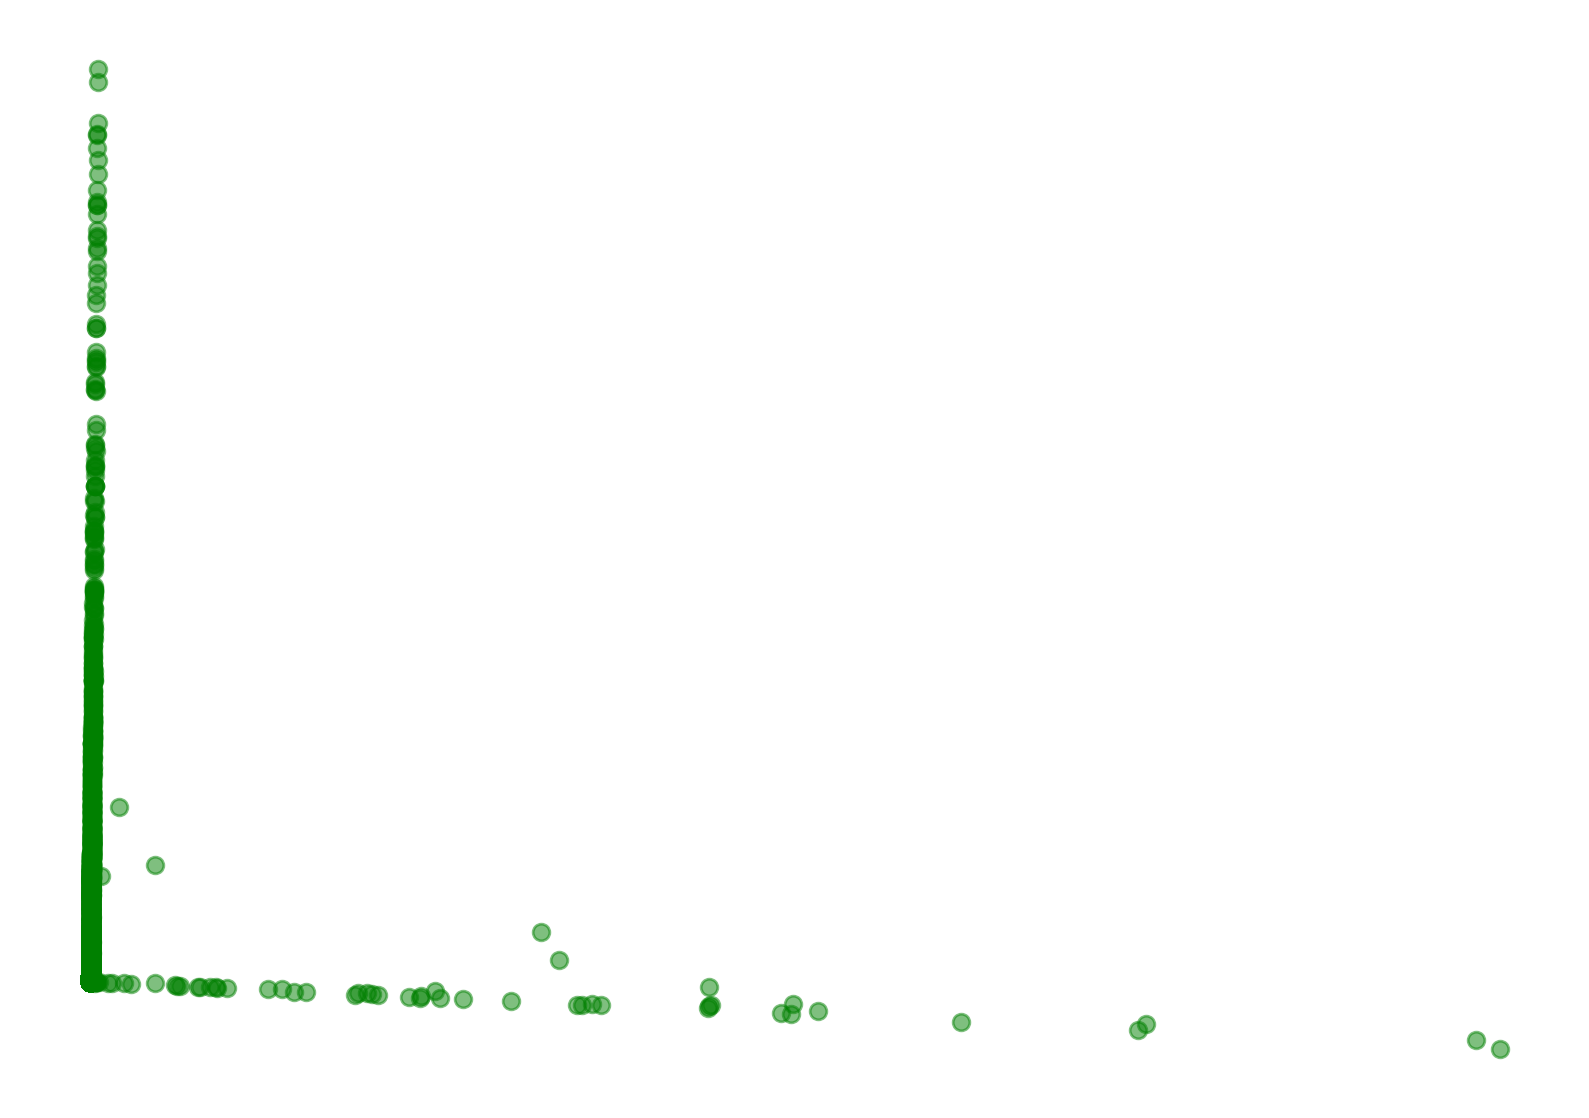

In [9]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

### Test for library saturation

For each cell we ask how many genes did we detect (or see non-zero expression). The idea is that if we have "saturated" our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

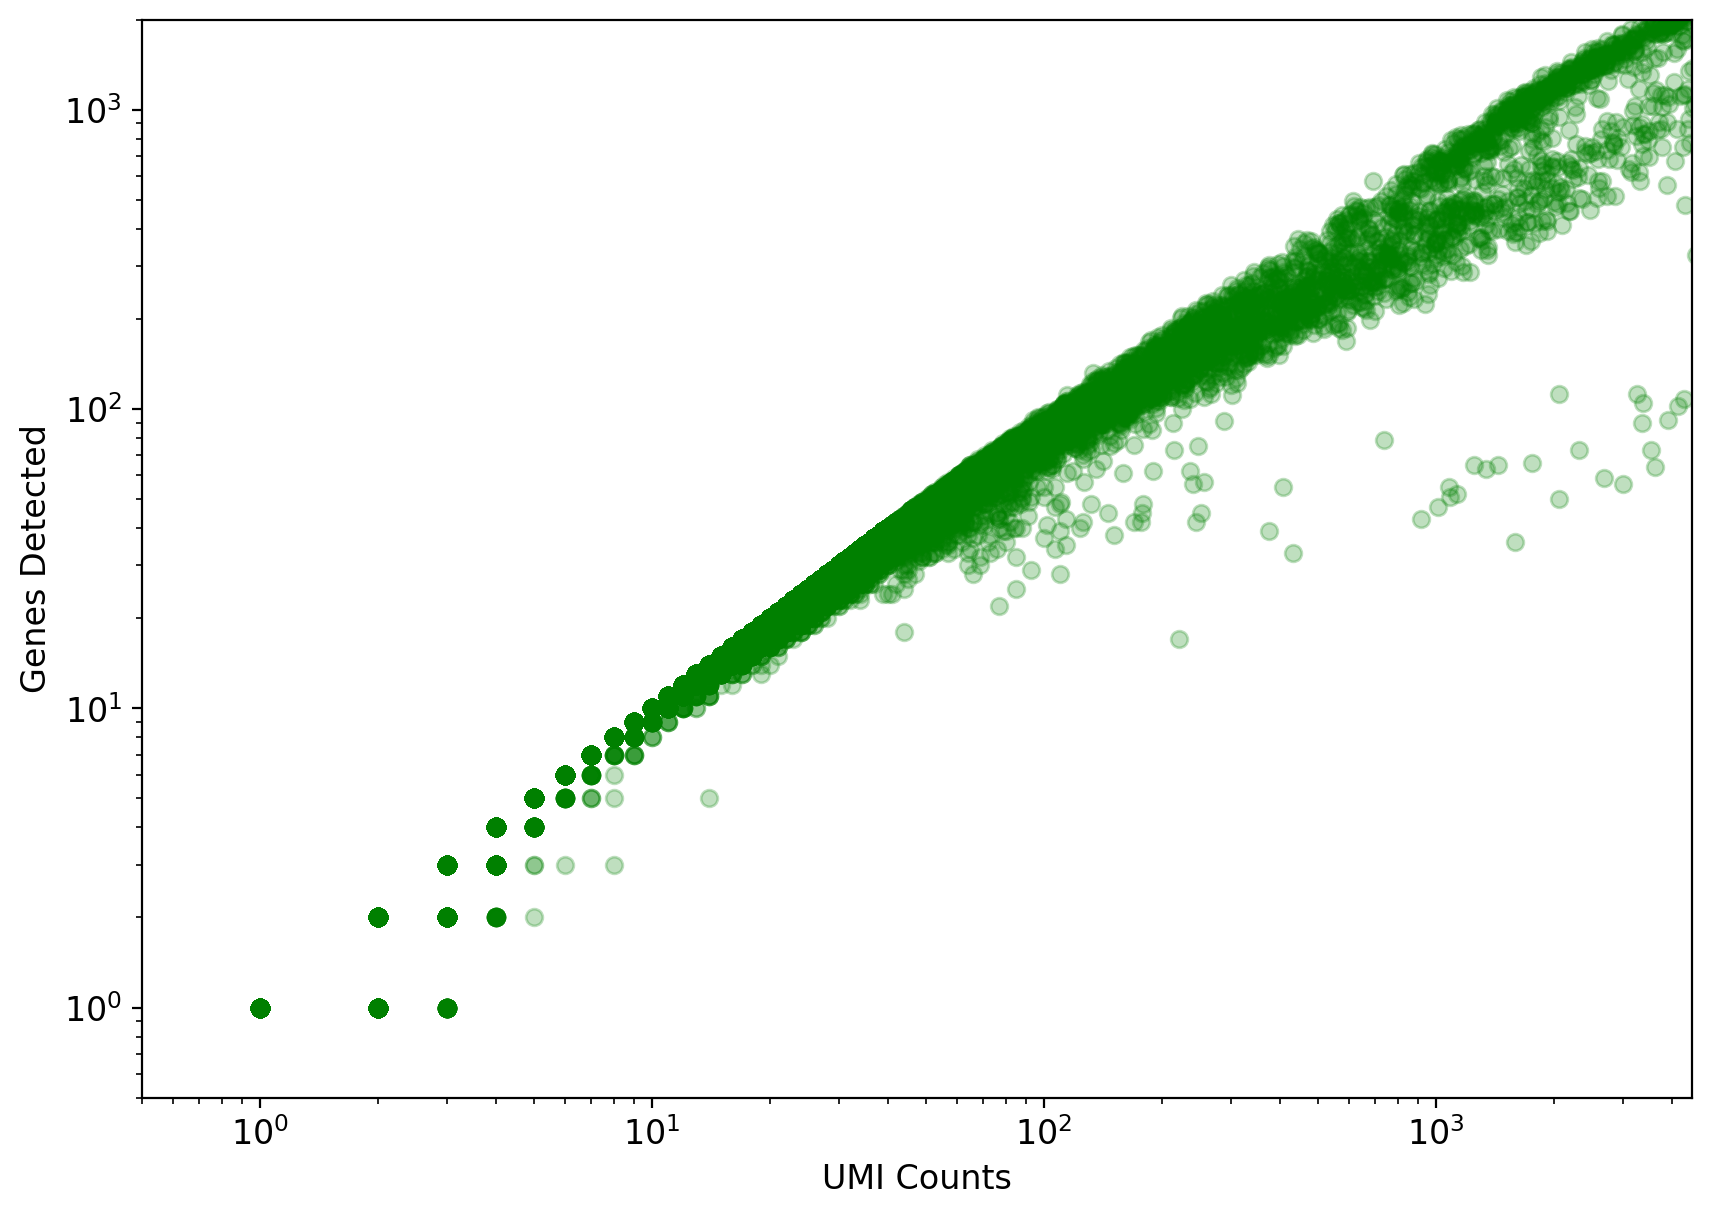

In [10]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper:
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells.

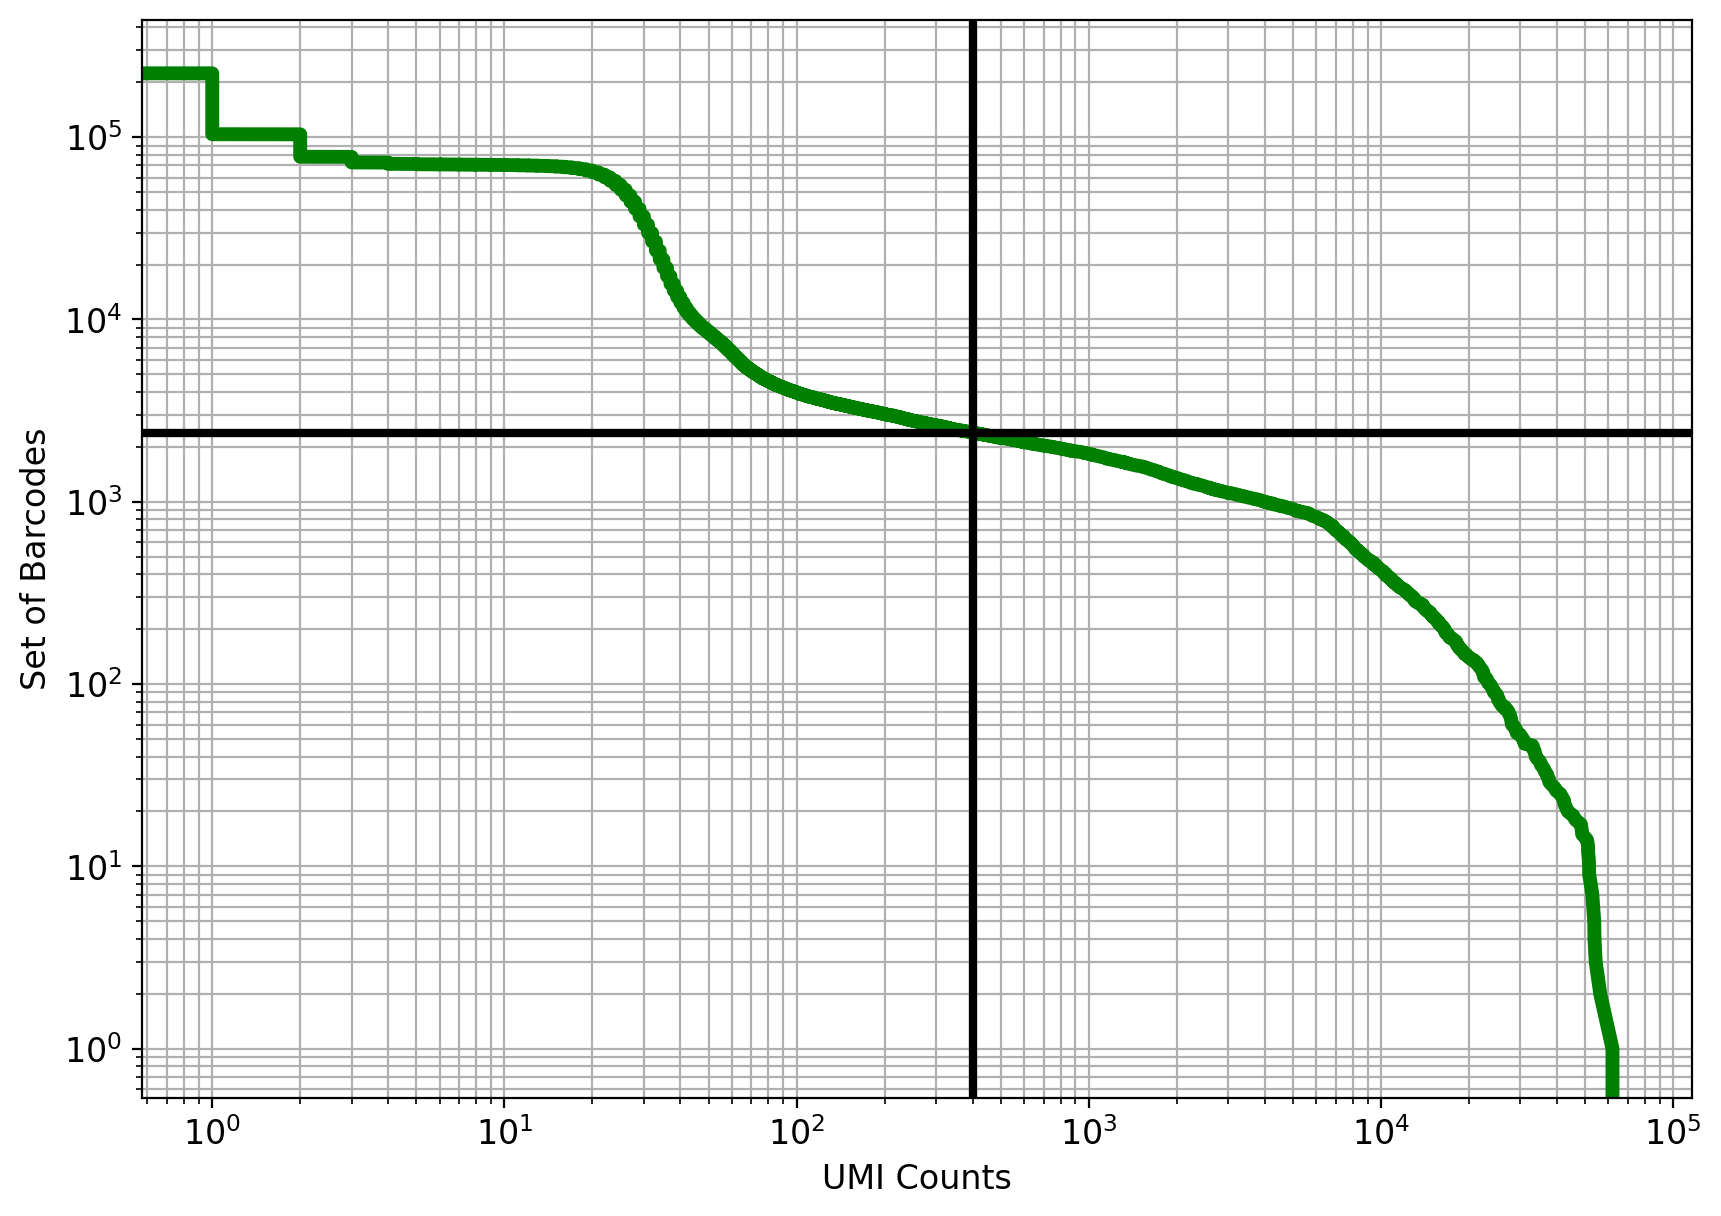

In [11]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 400  #@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [12]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

2,397 cells passed the 400 UMI threshold


### Filter empty droplets

In [13]:
adata

AnnData object with n_obs × n_vars = 237731 × 34183

In [14]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[num_cells])

In [15]:
adata

AnnData object with n_obs × n_vars = 2323 × 34183
    obs: 'n_genes', 'n_counts'

### Filtering out by mitochondrial content

In [16]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")
mito_genes = set(mito_ensembl_ids["ensembl_gene_id"].values)

adata_base_var_names = adata.var_names.str.split('.').str[0]  # Removes minor version from var names
mito_genes_base = {gene.split('.')[0] for gene in mito_genes}  # Removes minor version from mito_genes

# Identify mitochondrial genes in adata.var using the stripped version of gene IDs
adata.var['is_mito'] = adata_base_var_names.isin(mito_genes_base)

mito_counts = adata[:, adata.var['is_mito']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = adata.X.sum(axis=1)

# Calculate percent mitochondrial gene expression per cell
adata.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

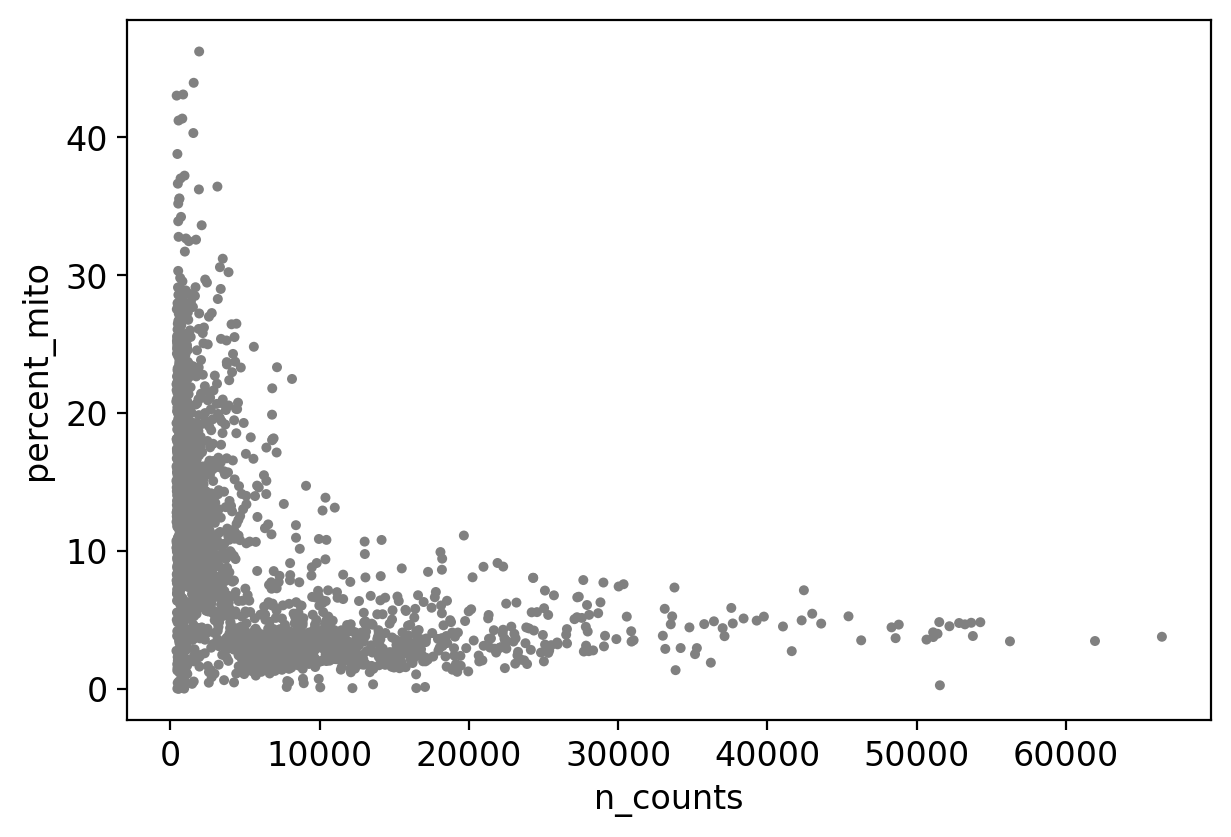

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [18]:
adata = adata[adata.obs.percent_mito < 30]

### Filter out genes that are not present in any cells

In [19]:
sc.pp.filter_genes(adata, min_cells=3)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [20]:
adata

AnnData object with n_obs × n_vars = 2295 × 17271
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'is_mito', 'n_cells'

### Visualizing count distributions

Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

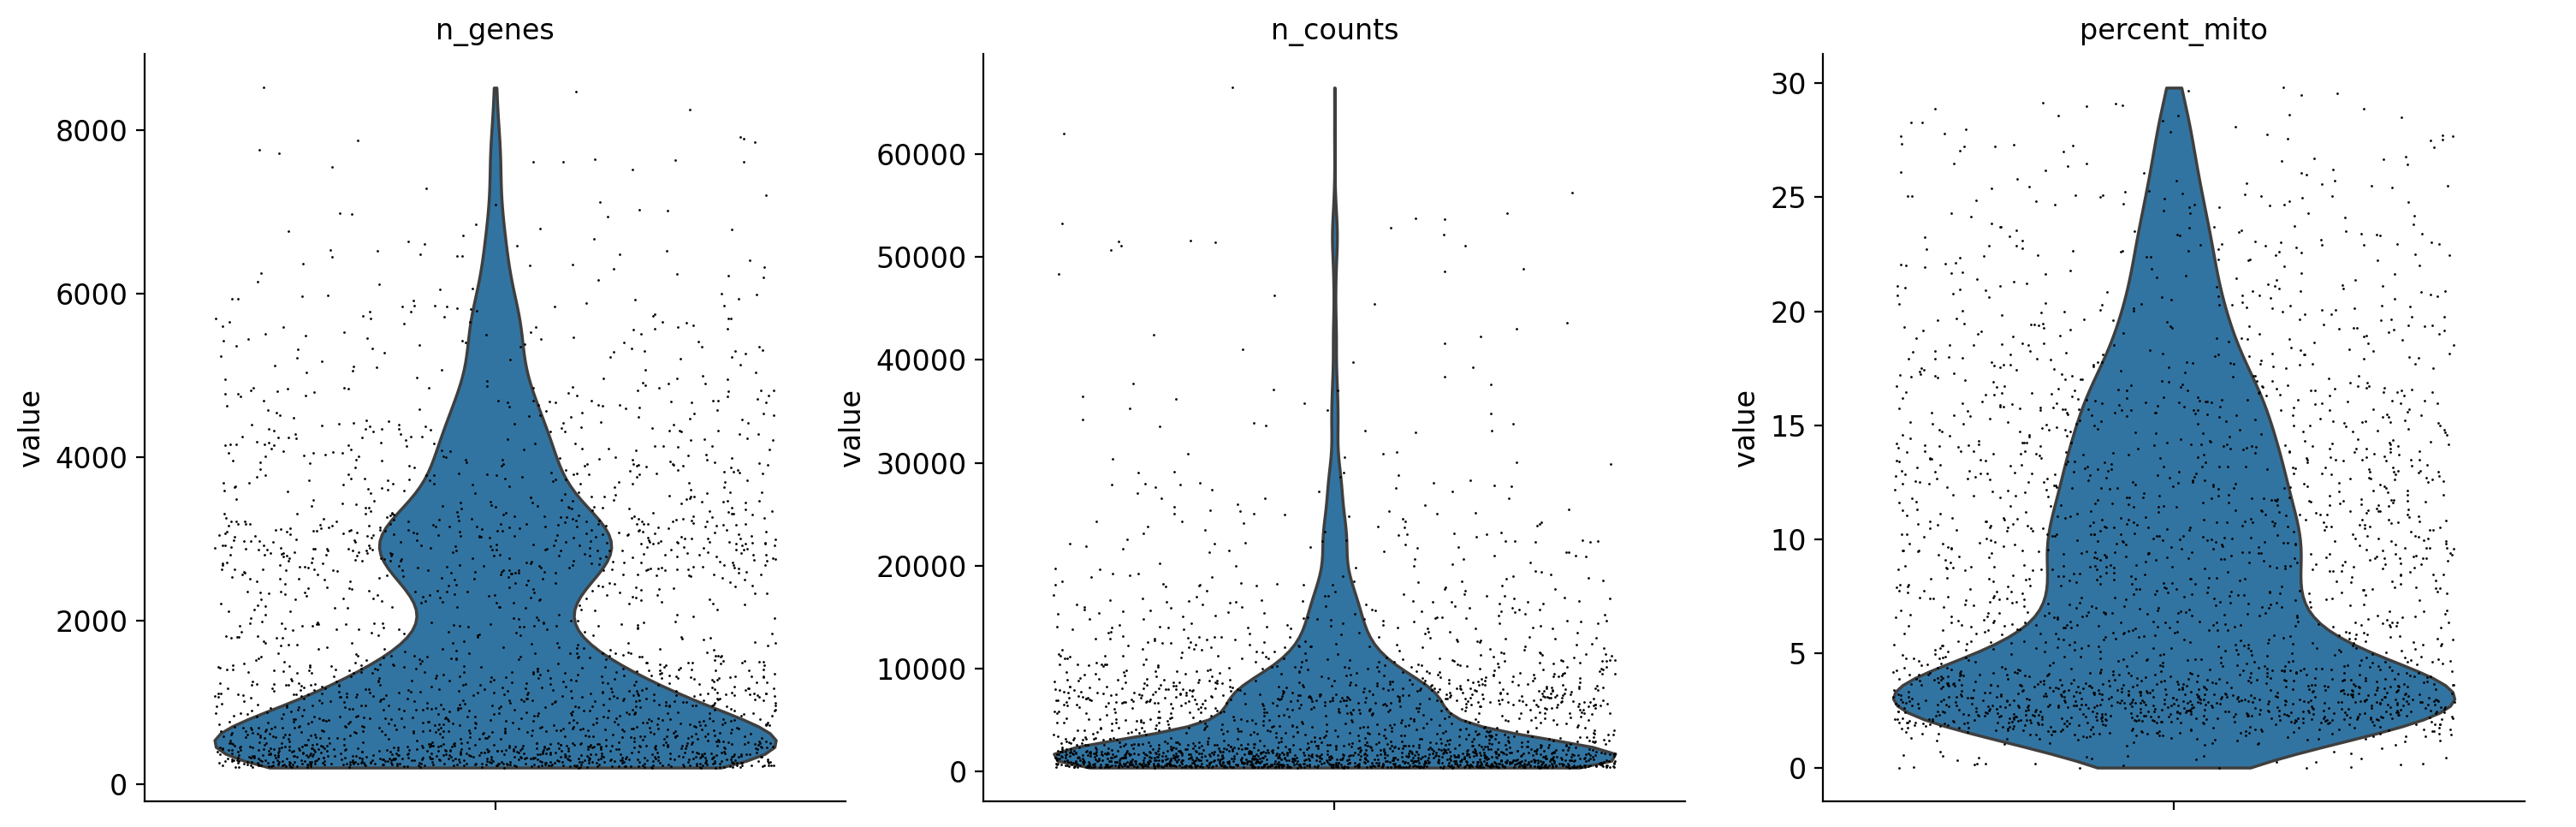

In [21]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

## Analysis

### Normalize the counts

In [22]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Identify highly variable genes

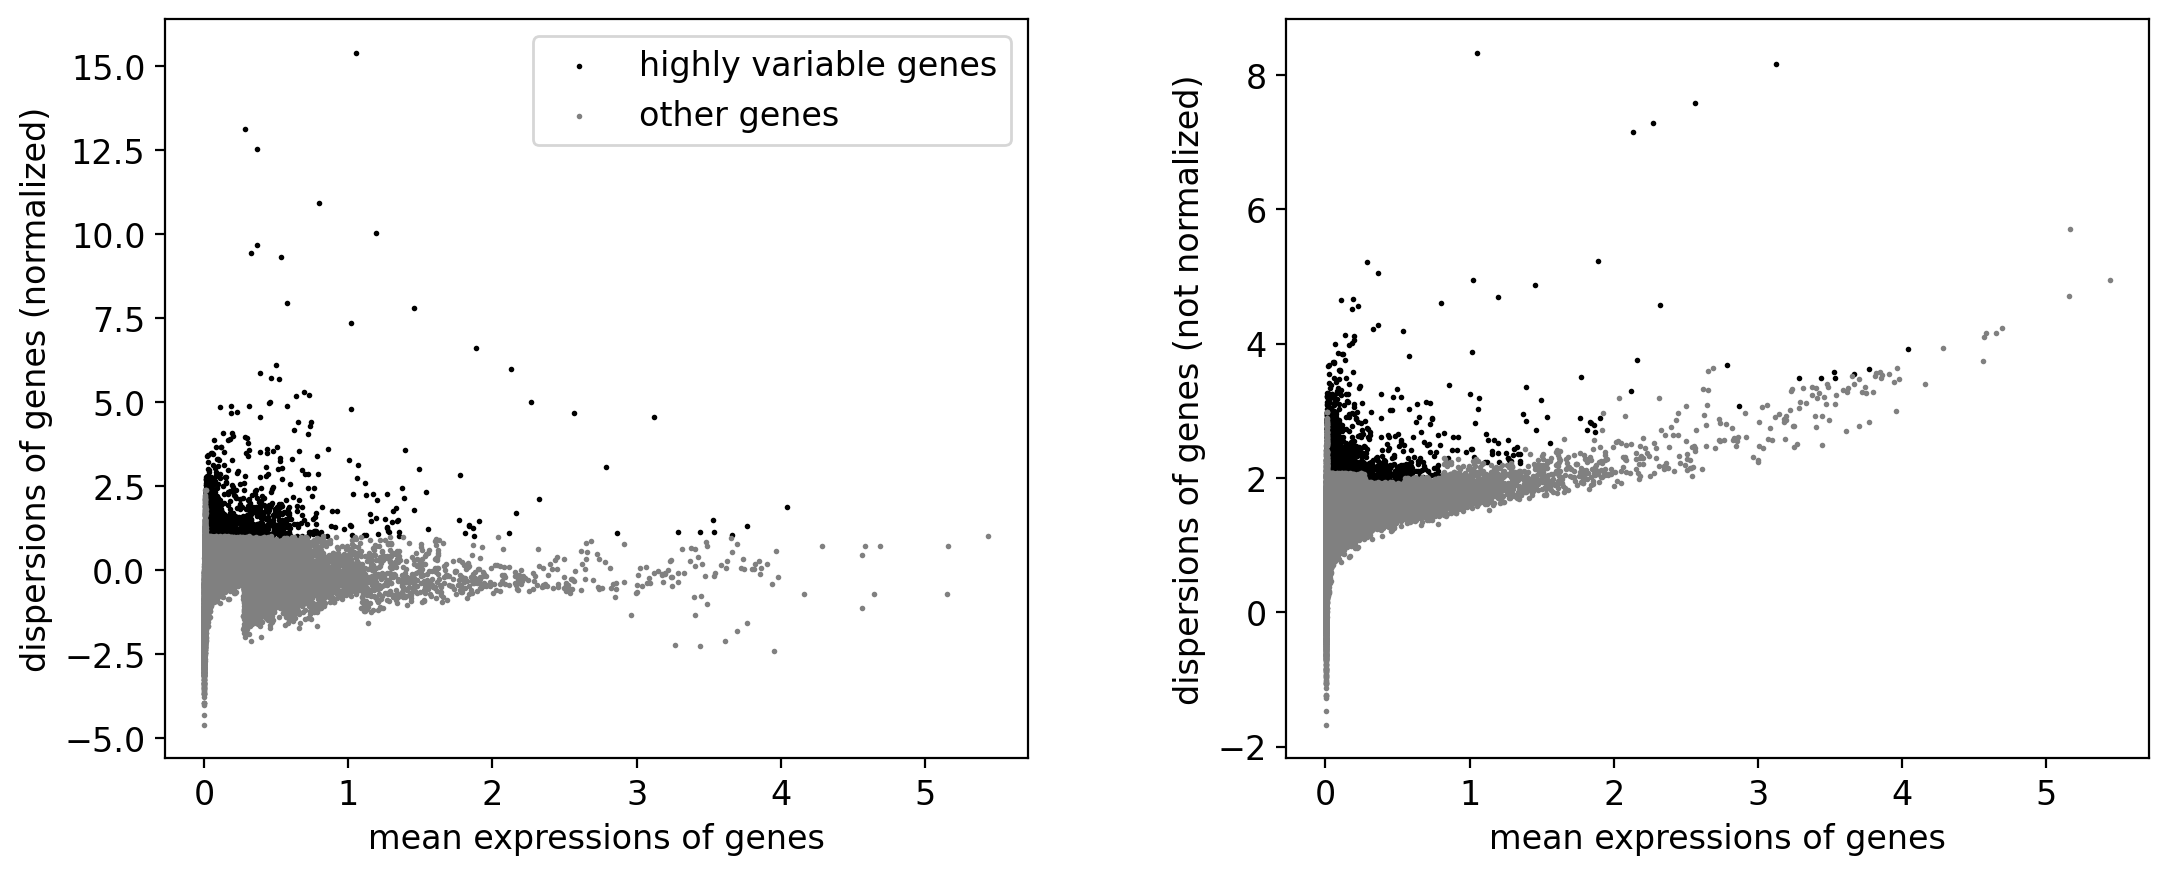

In [23]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [24]:
sc.pp.scale(adata, max_value=10)

### Clustering and visualization

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using [Louvain clustering](https://en.wikipedia.org/wiki/Louvain_modularity), which is a popular method for clustering single-cell RNA-seq data. The method was published in

- Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008.

In [25]:
sc.tl.pca(adata, svd_solver='arpack', mask_var="highly_variable", n_comps=10)

In [26]:
%%time
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', mask_var="highly_variable", n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

CPU times: user 21.1 s, sys: 4.75 s, total: 25.9 s
Wall time: 31.7 s


It is useful to revisit the PCA projection with points colored by cluster. Previously we computed the PCA projection directly; here we use a function in ScanPy which does the same.

### PCA

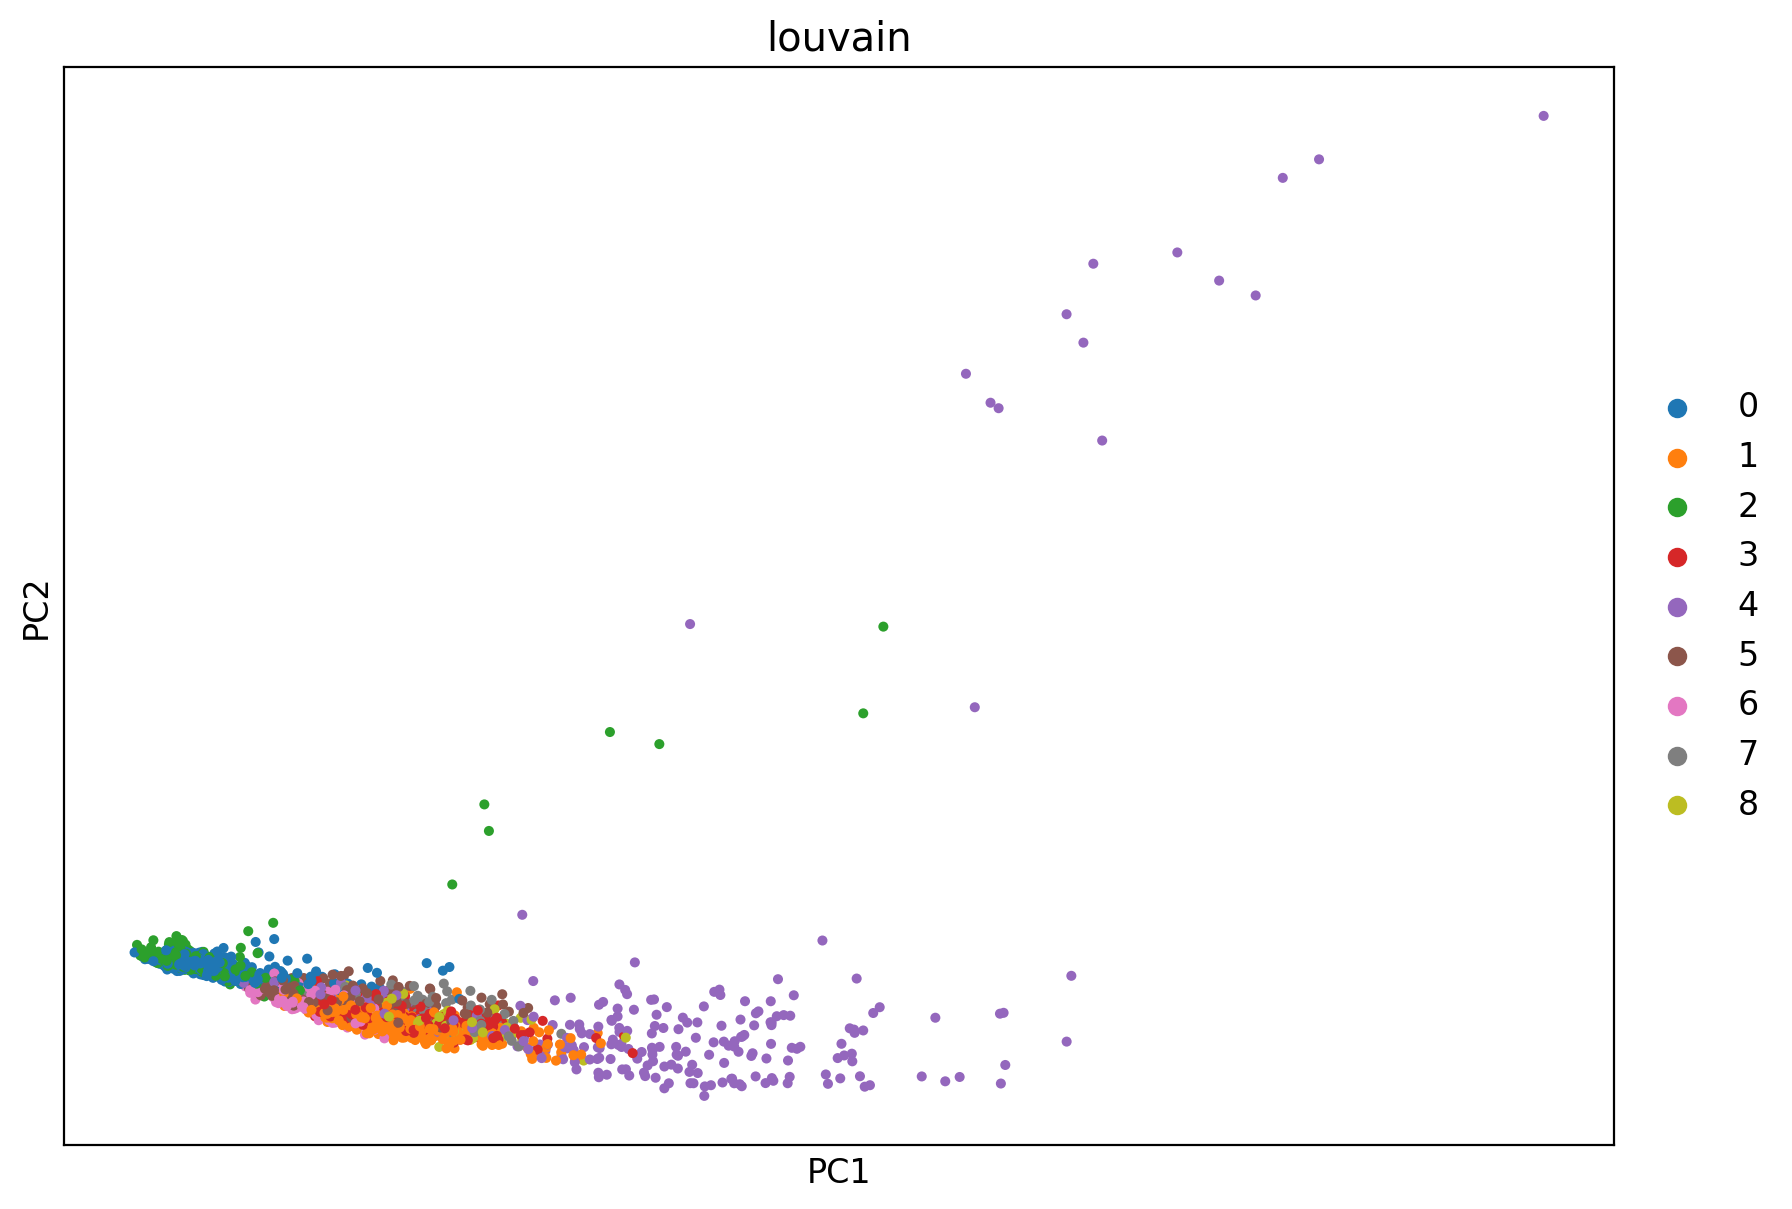

In [27]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

The PCA representation is the result a *linear* map of the data from its ambient dimension, to low dimension (in the case above 2D). While such projections are useful, there are *non-linear* methods that can capture non-linear geometry in the data.

### Visualization

Visualization of the clustered data can be accomplished through non-linear dimensionality reduction, often with [UMAP](https://umap-learn.readthedocs.io/en/latest/) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Our group has demonstrated that both UMAP and t-SNE's non-linear natures make their interpretability highly limited. To read more, please see the following reference:

- Chari T, Pachter L. The Specious Art of Single-Cell Genomics [Internet]. Genomics; 2021 Aug [cited 2023 Sep 6]. Available from: http://biorxiv.org/lookup/doi/10.1101/2021.08.25.457696

However, for those still interested in these methods, we demonstrate their use below.

#### t-SNE

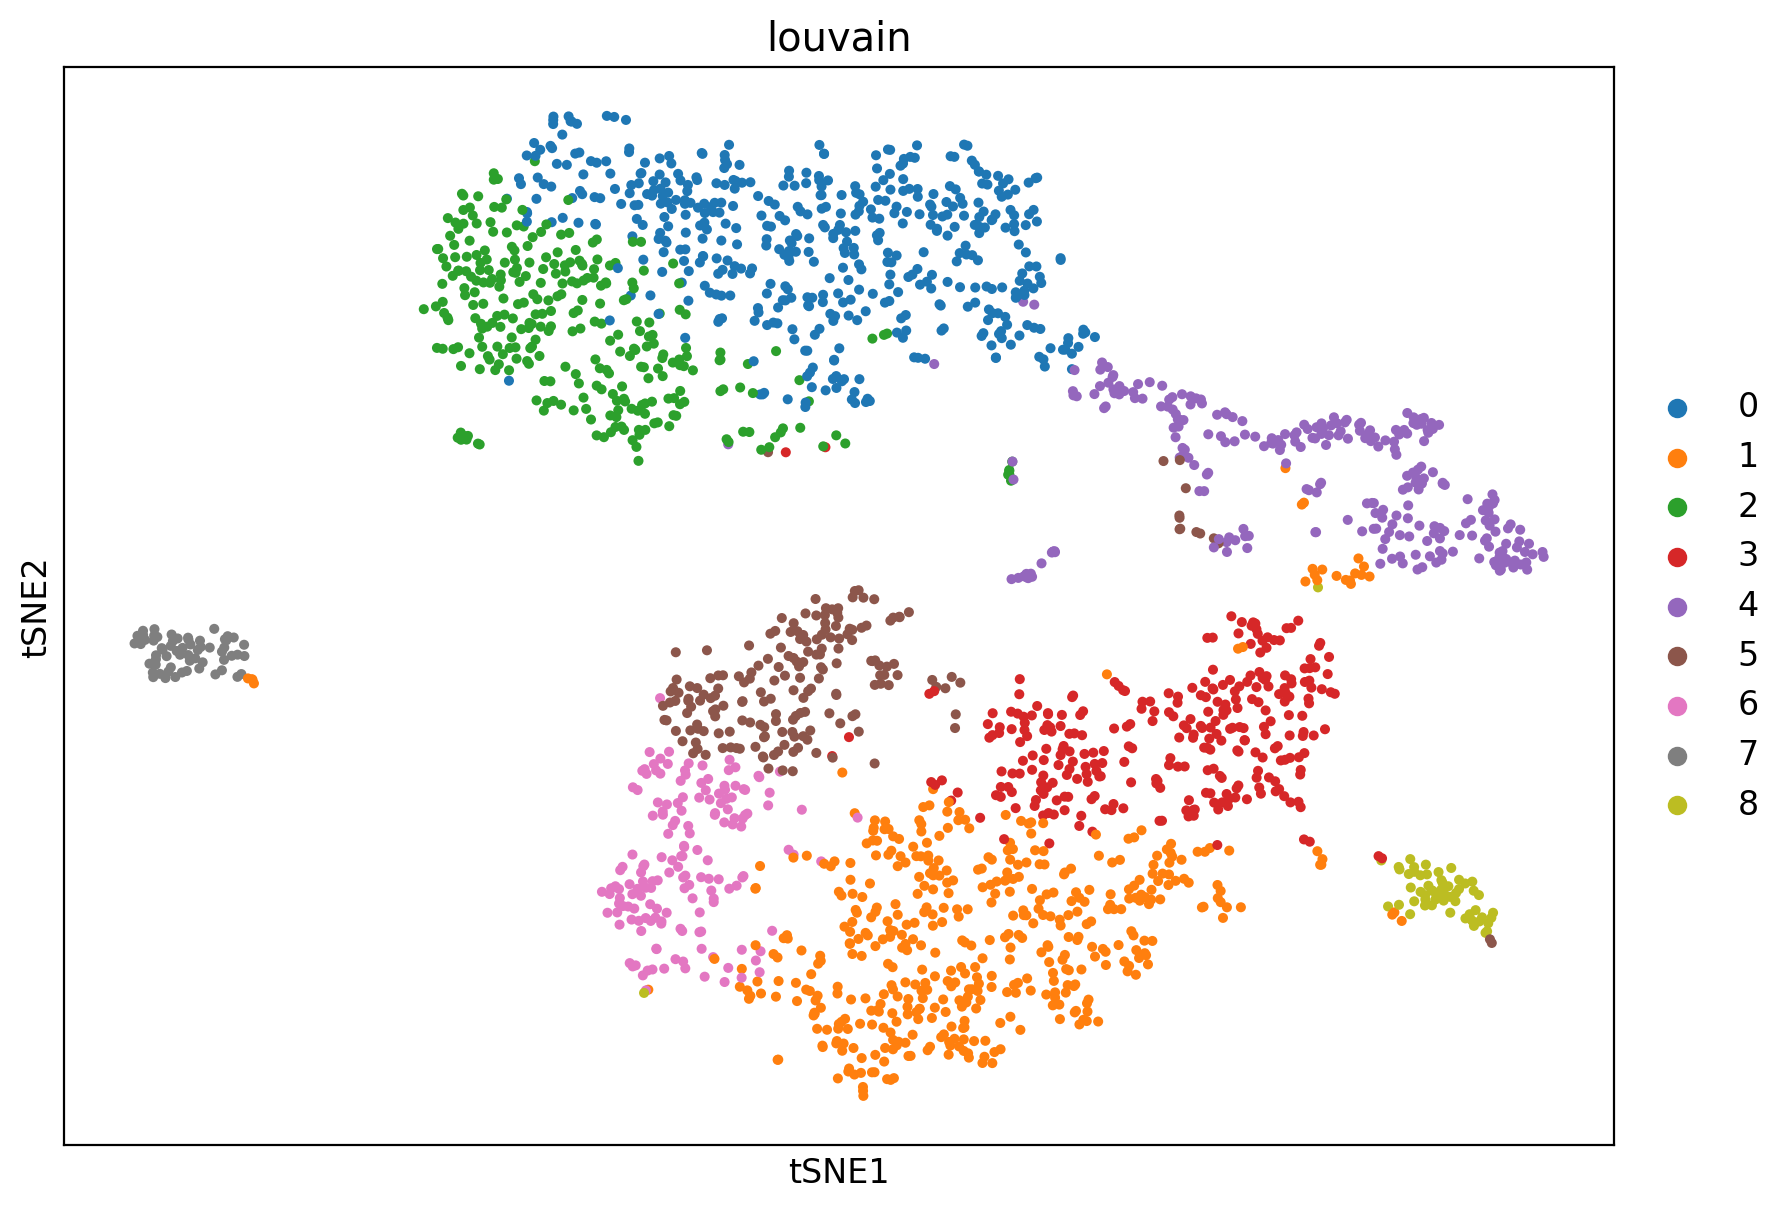

CPU times: user 19.6 s, sys: 60.9 ms, total: 19.7 s
Wall time: 19.7 s


In [28]:
%%time
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

#### UMAP

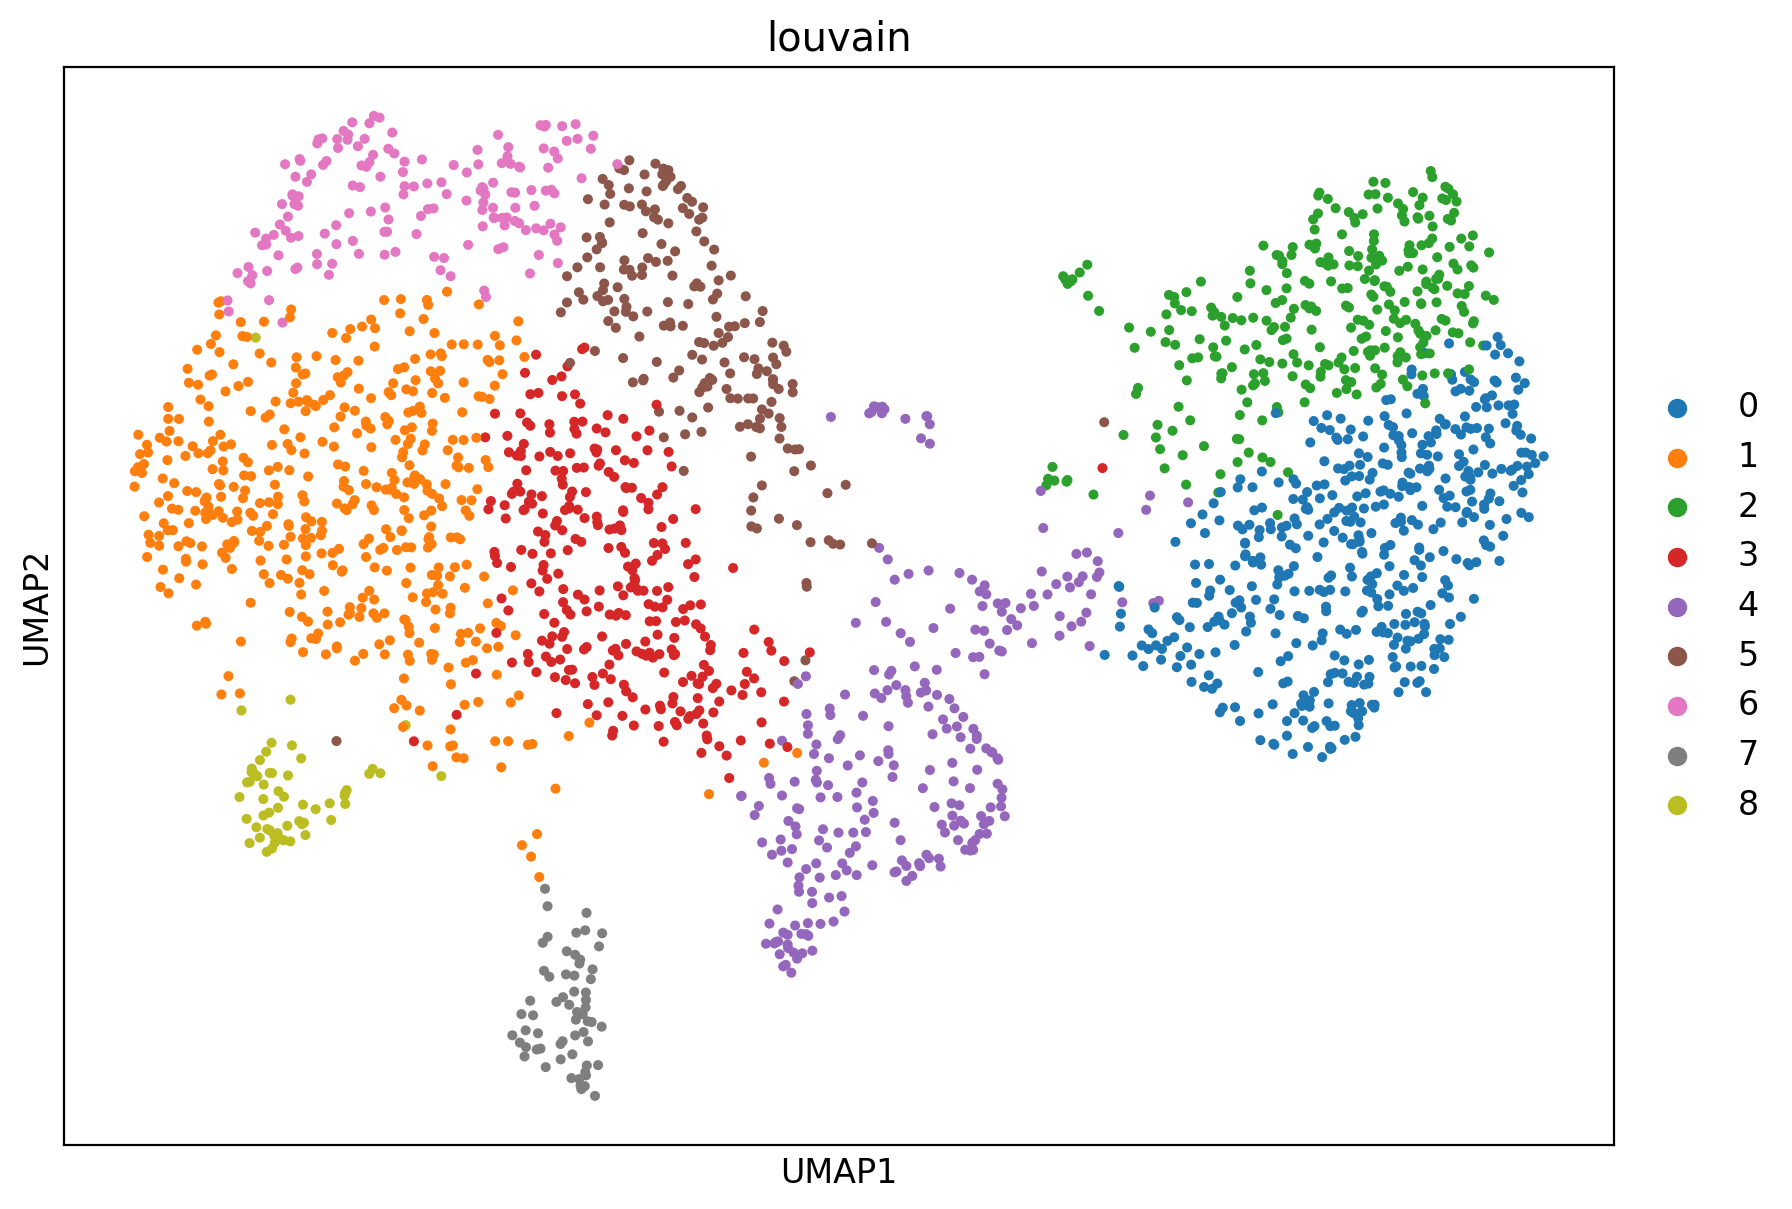

CPU times: user 5.47 s, sys: 150 ms, total: 5.62 s
Wall time: 5.36 s


In [29]:
%%time
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### Discussion

This notebook has demonstrated visualization of cells following pre-processing of single-nucleus RNA-seq data.

In [30]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

45.98 minutes
